In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential,  Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate,Reshape, LSTM, CuDNNLSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
from google.colab import drive
import tensorflow as tf
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ECE-176

/content/drive/.shortcut-targets-by-id/1nocF8OwSC30SO-c6lZ_zjX725MCTIjid/ECE-176


In [ ]:
basePath = os.getcwd()

In [ ]:
# Helper Functions

def fetch_data(path_to_folder1, path_to_folder2, path_to_folder3, path_to_folder4, label_dict):
  # define lists to hold image data and corresponding labels
  data = []
  labels = []

  # loop through each folder and read images
  for folder in [path_to_folder1, path_to_folder2, path_to_folder3, path_to_folder4]:
      for filename in os.listdir(folder):
          img = cv2.imread(os.path.join(folder, filename))
          if img is not None:
              # resize image if needed
              # img = cv2.resize(img, (256, 256))
              # img = cv2.resize(img, (80, 60))
              img = cv2.resize(img, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
              # convert image to numpy array and append to data list
              data.append(np.array(img))
              # get label from folder name and append to labels list
              label = label_dict[os.path.basename(folder)]
              labels.append(label)

  data, labels = np.array(data), np.array(labels)
  # data = np.transpose(data, (0, 3, 1, 2)) # rearranges shape from (369, 256, 256, 3) to (369, 3, 256, 256)

  return data, labels

In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix


def rgb_to_grayscale(input):
    """Convert an RGB image to grayscale by averaging across color channels."""
    return tf.reduce_mean(input, axis=3)

def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./loss_curve.png')

def shuffle_data(data, labels):
  '''shuffle data and labels together'''

  indices = np.arange(len(data))
  np.random.shuffle(indices)
  data = data[indices]
  labels = labels[indices]

  return data, labels

In [ ]:
# Load original Data
p1 = basePath + '/dataset-master/JPEGImages/classes/EOSINOPHIL'
p2 = basePath + '/dataset-master/JPEGImages/classes/LYMPHOCYTE'
p3 =  basePath + '/dataset-master/JPEGImages/classes/MONOCYTE'
p4 =  basePath + '/dataset-master/JPEGImages/classes/NEUTROPHIL'

# define dictionary to map folder name to label
label_dict = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
num_classes = 4

data_loaded, labels_loaded = fetch_data(p1, p2, p3, p4, label_dict)

In [ ]:
# # Load augmented data
# p1 = basePath + '/dataset-master/GAN AUGMENTED DATA/eos'
# p2 = basePath + '/dataset-master/GAN AUGMENTED DATA/lymph'
# p3 =  basePath + '/dataset-master/GAN AUGMENTED DATA/mono'
# p4 =  basePath + '/dataset-master/GAN AUGMENTED DATA/neutro'

# # define dictionary to map folder name to label
# label_dict = {'eos': 0, 'lymph': 1, 'mono': 2, 'neutro': 3}
# num_classes = 4

# data_augment, labels_augment = fetch_data(p1, p2, p3, p4, label_dict)

In [ ]:
# data_loaded.shape, data_augment.shape

In [ ]:
# data_total = np.concatenate((data_loaded, data_augment), axis=0)
# labels_total = np.concatenate((labels_loaded, labels_augment), axis=0)

# data_total.shape, labels_total.shape

In [ ]:
# Shuffle data and convert labels to one hot encodings

# data, labels = shuffle_data(data_total, labels_total)
data, labels = shuffle_data(data_loaded, labels_loaded)

labels = to_categorical(labels, num_classes = 4)
print('data shape: ', data.shape)
print('labels shape: ', labels.shape)

data shape:  (369, 60, 80, 3)
labels shape:  (369, 4)


In [ ]:
# split data and labels into training, validation, and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.15, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)

# print the shapes of the training and testing sets ~ all y's are one hot encoded
print('xtrain shape:', xtrain.shape)
print('ytrain shape:', ytrain.shape)
print('xval shape:', xval.shape)
print('yval shape:', yval.shape)
print('xtest shape:', xtest.shape)
print('ytest shape:', ytest.shape)

xtrain shape: (266, 60, 80, 3)
ytrain shape: (266, 4)
xval shape: (47, 60, 80, 3)
yval shape: (47, 4)
xtest shape: (56, 60, 80, 3)
ytest shape: (56, 4)


In [ ]:
def runCNNRNNAugment(x_train,y_train,x_val,y_val, stride, epochs, bsize):

    batch_size = bsize
    num_classes = 4
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)

    # Creating CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=stride))
    modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    # modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))
    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)

    # Creating RNN
    modelrnn = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
    #modelrnn = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    #rnn_output = Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    modelrnn = Bidirectional(CuDNNLSTM(64, return_sequences=True))(modelrnn)
    #modelrnn = Dropout(0.25)(modelrnn)
    rnn_output = Bidirectional(CuDNNLSTM(64))(modelrnn)
    rnn_output = Dropout(0.25)(rnn_output)

    # Merging both cnn bottleneck and rnn's output wise element wise multiplication
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(128, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    print(model.summary())


    # datagen = ImageDataGenerator(
    #     featurewise_center=False,  # set input mean to 0 over the dataset
    #     samplewise_center=False,  # set each sample mean to 0
    #     featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #     samplewise_std_normalization=False,  # divide each input by its std
    #     zca_whitening=False,  # apply ZCA whitening
    #     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    #     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    #     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #     horizontal_flip=True,  # randomly flip images
    #     vertical_flip=False)  # randomly flip images
    # history = model.fit_generator(datagen.flow(a,b, batch_size=32),
    #                     steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])

    # history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))
    history = []

    return model, history

In [ ]:
bsize = 128
epochs = 80
stride = 1
runCNNRNNAugment(xtrain, ytrain, xval, yval, stride, epochs, bsize)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 80)       0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 60, 128)      74752       ['lambda[0][0]']                 
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         99328       ['bidirectional[0][0]']          
 )                                                                                            

(<keras.engine.functional.Functional at 0x7fbf9412b070>, [])

In [ ]:
bsize = 128
epochs = 80
stride = 1
trained_model, hist = runCNNRNNAugment(xtrain, ytrain, xval, yval, stride, epochs, bsize)

Epoch 1/80
3/3 [==============================] - 14s 478ms/step - loss: 648.1407 - accuracy: 0.3008 - val_loss: 435.7474 - val_accuracy: 0.6383
Epoch 2/80
3/3 [==============================] - 0s 49ms/step - loss: 540.9067 - accuracy: 0.4549 - val_loss: 71.9378 - val_accuracy: 0.2766
Epoch 3/80
3/3 [==============================] - 0s 51ms/step - loss: 72.2794 - accuracy: 0.2669 - val_loss: 1.5538 - val_accuracy: 0.6383
Epoch 4/80
3/3 [==============================] - 0s 49ms/step - loss: 2.2712 - accuracy: 0.5226 - val_loss: 1.2699 - val_accuracy: 0.3191
Epoch 5/80
3/3 [==============================] - 0s 50ms/step - loss: 1.2640 - accuracy: 0.4624 - val_loss: 1.1064 - val_accuracy: 0.6170
Epoch 6/80
3/3 [==============================] - 0s 51ms/step - loss: 1.1471 - accuracy: 0.6090 - val_loss: 0.9833 - val_accuracy: 0.7447
Epoch 7/80
3/3 [==============================] - 0s 49ms/step - loss: 1.0846 - accuracy: 0.5602 - val_loss: 1.2034 - val_accuracy: 0.6383
Epoch 8/80
3/3 [=


Keras CNN #1C - accuracy: 0.981203019618988 

Train loss: 0.05098686367273331
Train accuracy: 0.981203019618988
9/9 [==============================] - 1s 9ms/step

              precision    recall  f1-score   support

  EOSINOPHIL       0.99      0.97      0.98        72
  LYMPHOCYTE       0.94      1.00      0.97        29
    MONOCYTE       1.00      0.88      0.94        17
  NEUTROPHIL       0.99      0.99      0.99       148

    accuracy                           0.98       266
   macro avg       0.98      0.96      0.97       266
weighted avg       0.98      0.98      0.98       266



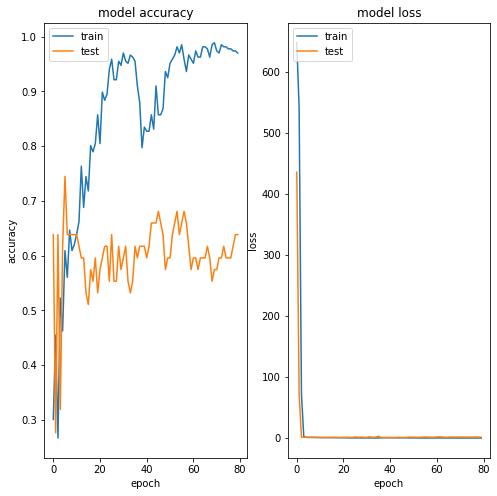

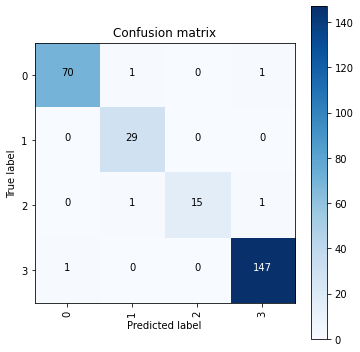

In [ ]:
score = trained_model.evaluate(xtrain, ytrain, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')
print('Train loss:', score[0])
print('Train accuracy:', score[1])

y_pred = trained_model.predict(xtrain)
map_characters = label_dict
print('\n', sklearn.metrics.classification_report(np.where(ytrain > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.keys())), sep='')
Y_pred_classes = np.argmax(y_pred,axis=1)
Y_true = np.argmax(ytrain,axis=1)
# plotKerasLearningCurve()
# plt.show()
plot_learning_curve(hist)
# plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = list(label_dict.values()))
plt.show()


Keras CNN #1C - accuracy: 0.5892857313156128 

Test loss: 2.3968091011047363
Test accuracy: 0.5892857313156128
2/2 [==============================] - 0s 12ms/step

              precision    recall  f1-score   support

  EOSINOPHIL       0.14      0.11      0.12         9
  LYMPHOCYTE       0.00      0.00      0.00         6
    MONOCYTE       0.00      0.00      0.00         4
  NEUTROPHIL       0.67      0.86      0.75        37

    accuracy                           0.59        56
   macro avg       0.20      0.24      0.22        56
weighted avg       0.46      0.59      0.52        56



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


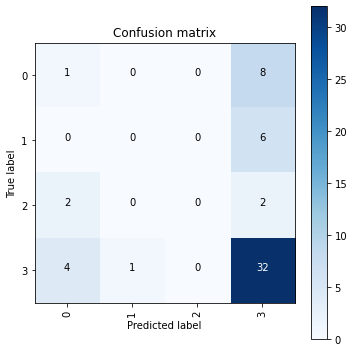

In [ ]:
# Test set results
score = trained_model.evaluate(xtest, ytest, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = trained_model.predict(xtest)
map_characters = label_dict
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.keys())), sep='')
Y_pred_classes = np.argmax(y_pred,axis=1)
Y_true = np.argmax(ytest,axis=1)
# plotKerasLearningCurve()
# plt.show()
# plot_learning_curve(hist)
# plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = list(label_dict.values()))
plt.show()

In [ ]:
# save the trained model
modelPath = basePath + '/models/'
trained_model.save(modelPath + 'vysh_cnn-rnn-og.h5')

# save the history object
with open(modelPath + 'hist-vysh_cnn-rnn-og.pickle', 'wb') as handle:
    pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)